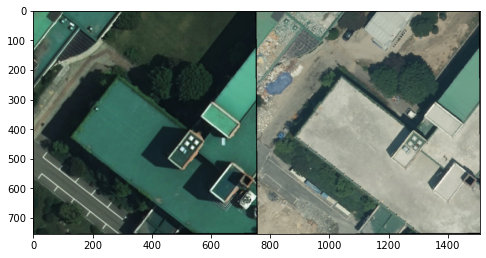

In [1]:
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/train/x/2015_DMG_1LB_000006.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [2]:
data_root = 'data/train'
img_dir = 'x'
ann_dir = 'y'

In [3]:
# import os.path as osp
# import numpy as np
# from PIL import Image
# # convert dataset annotation to semantic segmentation map
# # split train/val set randomly

# split_dir = 'splits'
# mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
#     osp.join(data_root, ann_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*4/5)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

In [4]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import os.path as osp

classes = ('background', 'new', 'destroy', 'upgrade')
palette = [[0, 0, 0], [0, 0, 128], [128, 0, 0],[0, 128, 0]]

@DATASETS.register_module()
class MAICONDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [6]:
# config_file = 'configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py' # mIoU 26.5?
config_file = 'configs/swin/upernet_swin_large_patch4_window7_512x512_pretrain_224x224_22K_160k_ade20k.py' # mIoU 26.5?
# config_file = 'configs/upernet/upernet_r101_512x512_160k_ade20k.py'
checkpoint_file = 'checkpoints/iter_100.pth'

In [7]:
# # build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [8]:
# # test a single image
# img = 'demo/demo.png'
# result = inference_segmentor(model, img)

In [9]:
# # show the results
# show_result_pyplot(model, img, result, get_palette('ade20k'))

In [10]:
from mmcv import Config
cfg = Config.fromfile(config_file)

In [11]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.l_norm_cfg = dict(type='LN', requires_grad=True) # for ViT backbone
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.l_norm_cfg
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 4
cfg.model.auxiliary_head.num_classes = 4

# Modify dataset type and path
cfg.dataset_type = 'MAICONDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
image_scale = (480, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=image_scale, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=image_scale,
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/maicon/upernet_swin_large_patch4_window7_512x512_pretrain_224x224_22K_160k_ade20k'

# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000) 

cfg.runner.max_iters = 2000000
cfg.log_config.interval = 10000
cfg.evaluation.interval = 10000
cfg.checkpoint_config.interval = 10000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=192,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[6, 12, 24, 48],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        use_abs_pos_embed=False,
        act_cfg=dict(type='GELU'),
        norm_cfg=dict(type='LN', requires_grad=True),
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_large_patch4_window7_224_22k_20220412-aeecf2aa.pth'
        )),
    decode_head=dict(
       

In [12]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES



2022-11-29 16:41:26,964 - mmseg - INFO - Loaded 9600 images
/home/fds/Dev/Python/2022_AI_competition/maicon/ViT-Adapter/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [13]:
model

EncoderDecoder(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=192, out_features=576, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=192, out_features=192, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (norm2): LayerNorm((192,), eps=1e-05, el

In [14]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-11-29 16:41:31,074 - mmseg - INFO - Loaded 2398 images
2022-11-29 16:41:31,076 - mmseg - INFO - Start running, host: fds@fds-X10SRA, work_dir: /home/fds/Dev/Python/2022_AI_competition/maicon/ViT-Adapter/mmseg/mmsegmentation/work_dirs/maicon/upernet_swin_large_patch4_window7_512x512_pretrain_224x224_22K_160k_ade20k
2022-11-29 16:41:31,077 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook       

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-29 19:25:01,983 - mmseg - INFO - per class results:
2022-11-29 19:25:01,985 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.33 | 99.92 |
|    new     |  0.28 |  0.29 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   |  2.14 |  2.22 |
+------------+-------+-------+
2022-11-29 19:25:01,986 - mmseg - INFO - Summary:
2022-11-29 19:25:01,987 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.3 | 24.69 | 25.61 |
+------+-------+-------+
2022-11-29 19:25:01,988 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9630, mIoU: 0.2469, mAcc: 0.2561, IoU.background: 0.9633, IoU.new: 0.0028, IoU.destroy: 0.0000, IoU.upgrade: 0.0214, Acc.background: 0.9992, Acc.new: 0.0029, Acc.destroy: 0.0000, Acc.upgrade: 0.0222
2022-11-29 19:40:52,618 - mmseg - INFO - Iter [11000/2000000]	lr: 5.967e-05, eta: 22 days, 12:30:28, time: 1.255, data_time: 0.311, memory: 9741, decode.loss_ce: 0.1683

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 302s, ETA:     0s

2022-11-29 22:08:34,035 - mmseg - INFO - per class results:
2022-11-29 22:08:34,036 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.38 | 99.92 |
|    new     |  0.0  |  0.0  |
|  destroy   |  0.0  |  0.0  |
|  upgrade   |  4.64 |  4.78 |
+------------+-------+-------+
2022-11-29 22:08:34,037 - mmseg - INFO - Summary:
2022-11-29 22:08:34,037 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.38 | 25.26 | 26.18 |
+-------+-------+-------+
2022-11-29 22:08:34,038 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9638, mIoU: 0.2526, mAcc: 0.2618, IoU.background: 0.9638, IoU.new: 0.0000, IoU.destroy: 0.0000, IoU.upgrade: 0.0464, Acc.background: 0.9992, Acc.new: 0.0000, Acc.destroy: 0.0000, Acc.upgrade: 0.0478
2022-11-29 22:24:24,936 - mmseg - INFO - Iter [21000/2000000]	lr: 5.937e-05, eta: 22 days, 10:33:24, time: 1.252, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-30 00:52:03,674 - mmseg - INFO - per class results:
2022-11-30 00:52:03,675 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.97 | 98.93 |
|    new     |  0.01 |  0.01 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 14.18 | 19.72 |
+------------+-------+-------+
2022-11-30 00:52:03,676 - mmseg - INFO - Summary:
2022-11-30 00:52:03,677 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.86 | 27.54 | 29.66 |
+-------+-------+-------+
2022-11-30 00:52:03,679 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9586, mIoU: 0.2754, mAcc: 0.2966, IoU.background: 0.9597, IoU.new: 0.0001, IoU.destroy: 0.0000, IoU.upgrade: 0.1418, Acc.background: 0.9893, Acc.new: 0.0001, Acc.destroy: 0.0000, Acc.upgrade: 0.1972
2022-11-30 01:07:55,872 - mmseg - INFO - Iter [31000/2000000]	lr: 5.907e-05, eta: 22 days, 8:04:54, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-11-30 03:35:47,357 - mmseg - INFO - per class results:
2022-11-30 03:35:47,358 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.48 | 99.83 |
|    new     |  1.15 |  1.16 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   |  9.14 |  9.81 |
+------------+-------+-------+
2022-11-30 03:35:47,359 - mmseg - INFO - Summary:
2022-11-30 03:35:47,359 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.44 | 26.69 | 27.7 |
+-------+-------+------+
2022-11-30 03:35:47,360 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9644, mIoU: 0.2669, mAcc: 0.2770, IoU.background: 0.9648, IoU.new: 0.0115, IoU.destroy: 0.0000, IoU.upgrade: 0.0914, Acc.background: 0.9983, Acc.new: 0.0116, Acc.destroy: 0.0000, Acc.upgrade: 0.0981
2022-11-30 03:51:39,472 - mmseg - INFO - Iter [41000/2000000]	lr: 5.877e-05, eta: 22 days, 5:39:09, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0.1553,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-11-30 06:19:37,606 - mmseg - INFO - per class results:
2022-11-30 06:19:37,608 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.45 |  99.5 |
|    new     |  4.28 |  4.58 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 14.79 | 17.53 |
+------------+-------+-------+
2022-11-30 06:19:37,608 - mmseg - INFO - Summary:
2022-11-30 06:19:37,609 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.37 | 28.88 | 30.4 |
+-------+-------+------+
2022-11-30 06:19:37,610 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9637, mIoU: 0.2888, mAcc: 0.3040, IoU.background: 0.9645, IoU.new: 0.0428, IoU.destroy: 0.0000, IoU.upgrade: 0.1479, Acc.background: 0.9950, Acc.new: 0.0458, Acc.destroy: 0.0000, Acc.upgrade: 0.1753
2022-11-30 06:35:31,102 - mmseg - INFO - Iter [51000/2000000]	lr: 5.847e-05, eta: 22 days, 3:11:28, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0.1509,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 302s, ETA:     0s

2022-11-30 09:03:15,560 - mmseg - INFO - per class results:
2022-11-30 09:03:15,561 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.42 | 99.55 |
|    new     |  10.4 |  14.9 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 12.59 | 13.92 |
+------------+-------+-------+
2022-11-30 09:03:15,562 - mmseg - INFO - Summary:
2022-11-30 09:03:15,563 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.36 | 29.85 | 32.09 |
+-------+-------+-------+
2022-11-30 09:03:15,565 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9636, mIoU: 0.2985, mAcc: 0.3209, IoU.background: 0.9642, IoU.new: 0.1040, IoU.destroy: 0.0000, IoU.upgrade: 0.1259, Acc.background: 0.9955, Acc.new: 0.1490, Acc.destroy: 0.0000, Acc.upgrade: 0.1392
2022-11-30 09:19:08,569 - mmseg - INFO - Iter [61000/2000000]	lr: 5.817e-05, eta: 22 days, 0:30:59, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-30 11:46:57,797 - mmseg - INFO - per class results:
2022-11-30 11:46:57,798 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.48 | 99.84 |
|    new     |  5.4  |  5.64 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   |  8.57 |  9.05 |
+------------+-------+-------+
2022-11-30 11:46:57,799 - mmseg - INFO - Summary:
2022-11-30 11:46:57,800 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.45 | 27.61 | 28.63 |
+-------+-------+-------+
2022-11-30 11:46:57,802 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9645, mIoU: 0.2761, mAcc: 0.2863, IoU.background: 0.9648, IoU.new: 0.0540, IoU.destroy: 0.0000, IoU.upgrade: 0.0857, Acc.background: 0.9984, Acc.new: 0.0564, Acc.destroy: 0.0000, Acc.upgrade: 0.0905
2022-11-30 12:02:49,878 - mmseg - INFO - Iter [71000/2000000]	lr: 5.787e-05, eta: 21 days, 21:51:21, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-30 14:30:29,790 - mmseg - INFO - per class results:
2022-11-30 14:30:29,792 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.47 | 99.73 |
|    new     |  6.68 |  7.02 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   |  10.7 | 11.71 |
+------------+-------+-------+
2022-11-30 14:30:29,793 - mmseg - INFO - Summary:
2022-11-30 14:30:29,794 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.44 | 28.46 | 29.62 |
+-------+-------+-------+
2022-11-30 14:30:29,795 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9644, mIoU: 0.2846, mAcc: 0.2962, IoU.background: 0.9647, IoU.new: 0.0668, IoU.destroy: 0.0000, IoU.upgrade: 0.1070, Acc.background: 0.9973, Acc.new: 0.0702, Acc.destroy: 0.0000, Acc.upgrade: 0.1171
2022-11-30 14:46:20,308 - mmseg - INFO - Iter [81000/2000000]	lr: 5.757e-05, eta: 21 days, 19:06:26, time: 1.252, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-30 17:14:19,878 - mmseg - INFO - per class results:
2022-11-30 17:14:19,879 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.54 | 99.79 |
|    new     |  9.9  | 10.86 |
|  destroy   |  0.13 |  0.13 |
|  upgrade   | 10.95 | 11.72 |
+------------+-------+-------+
2022-11-30 17:14:19,880 - mmseg - INFO - Summary:
2022-11-30 17:14:19,881 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.5 | 29.38 | 30.63 |
+------+-------+-------+
2022-11-30 17:14:19,882 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9650, mIoU: 0.2938, mAcc: 0.3063, IoU.background: 0.9654, IoU.new: 0.0990, IoU.destroy: 0.0013, IoU.upgrade: 0.1095, Acc.background: 0.9979, Acc.new: 0.1086, Acc.destroy: 0.0013, Acc.upgrade: 0.1172
2022-11-30 17:30:12,481 - mmseg - INFO - Iter [91000/2000000]	lr: 5.727e-05, eta: 21 days, 16:29:25, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 0.1414

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 302s, ETA:     0s

2022-11-30 19:58:04,434 - mmseg - INFO - per class results:
2022-11-30 19:58:04,435 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.51 | 99.62 |
|    new     | 12.69 | 14.36 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 13.54 | 15.24 |
+------------+-------+-------+
2022-11-30 19:58:04,436 - mmseg - INFO - Summary:
2022-11-30 19:58:04,436 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.46 | 30.69 | 32.3 |
+-------+-------+------+
2022-11-30 19:58:04,437 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9646, mIoU: 0.3069, mAcc: 0.3230, IoU.background: 0.9651, IoU.new: 0.1269, IoU.destroy: 0.0000, IoU.upgrade: 0.1354, Acc.background: 0.9962, Acc.new: 0.1436, Acc.destroy: 0.0000, Acc.upgrade: 0.1524
2022-11-30 20:13:55,749 - mmseg - INFO - Iter [101000/2000000]	lr: 5.697e-05, eta: 21 days, 13:48:15, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0.143

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-11-30 22:41:50,230 - mmseg - INFO - per class results:
2022-11-30 22:41:50,232 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.58 | 99.76 |
|    new     | 10.93 | 11.95 |
|  destroy   |  0.03 |  0.03 |
|  upgrade   | 12.43 | 13.49 |
+------------+-------+-------+
2022-11-30 22:41:50,232 - mmseg - INFO - Summary:
2022-11-30 22:41:50,233 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.53 | 29.99 | 31.31 |
+-------+-------+-------+
2022-11-30 22:41:50,235 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9653, mIoU: 0.2999, mAcc: 0.3131, IoU.background: 0.9658, IoU.new: 0.1093, IoU.destroy: 0.0003, IoU.upgrade: 0.1243, Acc.background: 0.9976, Acc.new: 0.1195, Acc.destroy: 0.0003, Acc.upgrade: 0.1349
2022-11-30 22:57:42,372 - mmseg - INFO - Iter [111000/2000000]	lr: 5.667e-05, eta: 21 days, 11:07:35, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-01 01:25:16,786 - mmseg - INFO - per class results:
2022-12-01 01:25:16,787 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.56 | 99.79 |
|    new     |  4.72 |  4.8  |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 12.36 | 13.32 |
+------------+-------+-------+
2022-12-01 01:25:16,788 - mmseg - INFO - Summary:
2022-12-01 01:25:16,789 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.53 | 28.41 | 29.48 |
+-------+-------+-------+
2022-12-01 01:25:16,789 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9653, mIoU: 0.2841, mAcc: 0.2948, IoU.background: 0.9656, IoU.new: 0.0472, IoU.destroy: 0.0000, IoU.upgrade: 0.1236, Acc.background: 0.9979, Acc.new: 0.0480, Acc.destroy: 0.0000, Acc.upgrade: 0.1332
2022-12-01 01:41:06,082 - mmseg - INFO - Iter [121000/2000000]	lr: 5.637e-05, eta: 21 days, 8:20:28, time: 1.250, data_time: 0.308, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 302s, ETA:     0s

2022-12-01 04:08:54,360 - mmseg - INFO - per class results:
2022-12-01 04:08:54,362 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.6 | 99.62 |
|    new     | 15.81 | 18.11 |
|  destroy   |  0.29 |  0.29 |
|  upgrade   |  15.1 | 17.04 |
+------------+-------+-------+
2022-12-01 04:08:54,363 - mmseg - INFO - Summary:
2022-12-01 04:08:54,364 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.54 | 31.95 | 33.77 |
+-------+-------+-------+
2022-12-01 04:08:54,365 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9654, mIoU: 0.3195, mAcc: 0.3377, IoU.background: 0.9660, IoU.new: 0.1581, IoU.destroy: 0.0029, IoU.upgrade: 0.1510, Acc.background: 0.9962, Acc.new: 0.1811, Acc.destroy: 0.0029, Acc.upgrade: 0.1704
2022-12-01 04:24:46,140 - mmseg - INFO - Iter [131000/2000000]	lr: 5.607e-05, eta: 21 days, 5:37:49, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-01 06:52:37,281 - mmseg - INFO - per class results:
2022-12-01 06:52:37,282 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.56 | 99.52 |
|    new     | 18.05 | 28.52 |
|  destroy   |  0.3  |  0.3  |
|  upgrade   | 14.58 | 16.15 |
+------------+-------+-------+
2022-12-01 06:52:37,283 - mmseg - INFO - Summary:
2022-12-01 06:52:37,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.46 | 32.37 | 36.12 |
+-------+-------+-------+
2022-12-01 06:52:37,287 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9646, mIoU: 0.3237, mAcc: 0.3612, IoU.background: 0.9656, IoU.new: 0.1805, IoU.destroy: 0.0030, IoU.upgrade: 0.1458, Acc.background: 0.9952, Acc.new: 0.2852, Acc.destroy: 0.0030, Acc.upgrade: 0.1615
2022-12-01 07:08:30,529 - mmseg - INFO - Iter [141000/2000000]	lr: 5.577e-05, eta: 21 days, 2:55:58, time: 1.257, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-01 09:36:25,432 - mmseg - INFO - per class results:
2022-12-01 09:36:25,433 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.6 | 99.69 |
|    new     | 13.24 | 15.69 |
|  destroy   |  0.02 |  0.02 |
|  upgrade   |  14.1 | 15.47 |
+------------+-------+-------+
2022-12-01 09:36:25,433 - mmseg - INFO - Summary:
2022-12-01 09:36:25,434 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.55 | 30.99 | 32.72 |
+-------+-------+-------+
2022-12-01 09:36:25,434 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9655, mIoU: 0.3099, mAcc: 0.3272, IoU.background: 0.9660, IoU.new: 0.1324, IoU.destroy: 0.0002, IoU.upgrade: 0.1410, Acc.background: 0.9969, Acc.new: 0.1569, Acc.destroy: 0.0002, Acc.upgrade: 0.1547
2022-12-01 09:52:18,494 - mmseg - INFO - Iter [151000/2000000]	lr: 5.547e-05, eta: 21 days, 0:14:36, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-01 12:19:57,274 - mmseg - INFO - per class results:
2022-12-01 12:19:57,275 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.55 |  99.4 |
|    new     | 17.11 | 23.26 |
|  destroy   |  0.76 |  0.76 |
|  upgrade   | 17.99 |  21.1 |
+------------+-------+-------+
2022-12-01 12:19:57,275 - mmseg - INFO - Summary:
2022-12-01 12:19:57,276 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.47 | 33.1 | 36.13 |
+-------+------+-------+
2022-12-01 12:19:57,277 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9647, mIoU: 0.3310, mAcc: 0.3613, IoU.background: 0.9655, IoU.new: 0.1711, IoU.destroy: 0.0076, IoU.upgrade: 0.1799, Acc.background: 0.9940, Acc.new: 0.2326, Acc.destroy: 0.0076, Acc.upgrade: 0.2110
2022-12-01 12:35:49,722 - mmseg - INFO - Iter [161000/2000000]	lr: 5.517e-05, eta: 20 days, 21:29:44, time: 1.254, data_time: 0.308, memory: 9741, decode.loss_ce: 0.137

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-01 15:03:44,302 - mmseg - INFO - per class results:
2022-12-01 15:03:44,304 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.68 |
|    new     | 11.26 | 11.97 |
|  destroy   |  0.11 |  0.11 |
|  upgrade   | 16.52 | 18.58 |
+------------+-------+-------+
2022-12-01 15:03:44,304 - mmseg - INFO - Summary:
2022-12-01 15:03:44,306 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 31.14 | 32.58 |
+-------+-------+-------+
2022-12-01 15:03:44,309 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3114, mAcc: 0.3258, IoU.background: 0.9668, IoU.new: 0.1126, IoU.destroy: 0.0011, IoU.upgrade: 0.1652, Acc.background: 0.9968, Acc.new: 0.1197, Acc.destroy: 0.0011, Acc.upgrade: 0.1858
2022-12-01 15:19:37,679 - mmseg - INFO - Iter [171000/2000000]	lr: 5.487e-05, eta: 20 days, 18:48:01, time: 1.256, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-01 17:47:40,242 - mmseg - INFO - per class results:
2022-12-01 17:47:40,243 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.54 | 99.53 |
|    new     | 14.61 | 18.69 |
|  destroy   |  1.06 |  1.07 |
|  upgrade   | 16.23 | 18.33 |
+------------+-------+-------+
2022-12-01 17:47:40,243 - mmseg - INFO - Summary:
2022-12-01 17:47:40,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.49 | 32.11 | 34.41 |
+-------+-------+-------+
2022-12-01 17:47:40,245 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9649, mIoU: 0.3211, mAcc: 0.3441, IoU.background: 0.9654, IoU.new: 0.1461, IoU.destroy: 0.0106, IoU.upgrade: 0.1623, Acc.background: 0.9953, Acc.new: 0.1869, Acc.destroy: 0.0107, Acc.upgrade: 0.1833
2022-12-01 18:03:34,377 - mmseg - INFO - Iter [181000/2000000]	lr: 5.457e-05, eta: 20 days, 16:07:32, time: 1.255, data_time: 0.308, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-01 20:31:29,644 - mmseg - INFO - per class results:
2022-12-01 20:31:29,645 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.67 |  99.7 |
|    new     | 13.47 | 15.88 |
|  destroy   |  2.5  |  2.59 |
|  upgrade   | 15.24 | 16.68 |
+------------+-------+-------+
2022-12-01 20:31:29,646 - mmseg - INFO - Summary:
2022-12-01 20:31:29,648 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.6 | 31.97 | 33.71 |
+------+-------+-------+
2022-12-01 20:31:29,649 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3197, mAcc: 0.3371, IoU.background: 0.9667, IoU.new: 0.1347, IoU.destroy: 0.0250, IoU.upgrade: 0.1524, Acc.background: 0.9970, Acc.new: 0.1588, Acc.destroy: 0.0259, Acc.upgrade: 0.1668
2022-12-01 20:47:27,109 - mmseg - INFO - Iter [191000/2000000]	lr: 5.427e-05, eta: 20 days, 13:26:03, time: 1.259, data_time: 0.309, memory: 9741, decode.loss_ce: 0.130

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 305s, ETA:     0s

2022-12-01 23:15:18,166 - mmseg - INFO - per class results:
2022-12-01 23:15:18,167 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.61 | 99.51 |
|    new     | 14.55 | 17.29 |
|  destroy   |  1.77 |  1.81 |
|  upgrade   | 17.74 | 20.62 |
+------------+-------+-------+
2022-12-01 23:15:18,168 - mmseg - INFO - Summary:
2022-12-01 23:15:18,168 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.54 | 32.67 | 34.81 |
+-------+-------+-------+
2022-12-01 23:15:18,169 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9654, mIoU: 0.3267, mAcc: 0.3481, IoU.background: 0.9661, IoU.new: 0.1455, IoU.destroy: 0.0177, IoU.upgrade: 0.1774, Acc.background: 0.9951, Acc.new: 0.1729, Acc.destroy: 0.0181, Acc.upgrade: 0.2062
2022-12-01 23:31:10,553 - mmseg - INFO - Iter [201000/2000000]	lr: 5.397e-05, eta: 20 days, 10:42:58, time: 1.257, data_time: 0.312, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 304s, ETA:     0s

2022-12-02 01:59:09,385 - mmseg - INFO - per class results:
2022-12-02 01:59:09,386 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.62 | 99.67 |
|    new     | 13.98 | 17.29 |
|  destroy   |  0.0  |  0.0  |
|  upgrade   | 14.78 | 16.21 |
+------------+-------+-------+
2022-12-02 01:59:09,386 - mmseg - INFO - Summary:
2022-12-02 01:59:09,388 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.56 | 31.34 | 33.29 |
+-------+-------+-------+
2022-12-02 01:59:09,389 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9656, mIoU: 0.3134, mAcc: 0.3329, IoU.background: 0.9662, IoU.new: 0.1398, IoU.destroy: 0.0000, IoU.upgrade: 0.1478, Acc.background: 0.9967, Acc.new: 0.1729, Acc.destroy: 0.0000, Acc.upgrade: 0.1621
2022-12-02 02:15:02,843 - mmseg - INFO - Iter [211000/2000000]	lr: 5.367e-05, eta: 20 days, 8:01:03, time: 1.258, data_time: 0.312, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 305s, ETA:     0s

2022-12-02 04:43:06,618 - mmseg - INFO - per class results:
2022-12-02 04:43:06,619 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.67 |  99.7 |
|    new     | 10.63 | 11.29 |
|  destroy   |  0.98 |  0.98 |
|  upgrade   | 16.41 |  18.2 |
+------------+-------+-------+
2022-12-02 04:43:06,620 - mmseg - INFO - Summary:
2022-12-02 04:43:06,621 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 31.17 | 32.55 |
+-------+-------+-------+
2022-12-02 04:43:06,621 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9662, mIoU: 0.3117, mAcc: 0.3255, IoU.background: 0.9667, IoU.new: 0.1063, IoU.destroy: 0.0098, IoU.upgrade: 0.1641, Acc.background: 0.9970, Acc.new: 0.1129, Acc.destroy: 0.0098, Acc.upgrade: 0.1820
2022-12-02 04:58:59,014 - mmseg - INFO - Iter [221000/2000000]	lr: 5.337e-05, eta: 20 days, 5:19:29, time: 1.258, data_time: 0.312, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 305s, ETA:     0s

2022-12-02 07:27:00,882 - mmseg - INFO - per class results:
2022-12-02 07:27:00,883 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.49 | 99.52 |
|    new     | 17.77 | 25.33 |
|  destroy   |  0.73 |  0.73 |
|  upgrade   | 14.37 | 15.99 |
+------------+-------+-------+
2022-12-02 07:27:00,883 - mmseg - INFO - Summary:
2022-12-02 07:27:00,884 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.44 | 32.34 | 35.39 |
+-------+-------+-------+
2022-12-02 07:27:00,884 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9644, mIoU: 0.3234, mAcc: 0.3539, IoU.background: 0.9649, IoU.new: 0.1777, IoU.destroy: 0.0073, IoU.upgrade: 0.1437, Acc.background: 0.9952, Acc.new: 0.2533, Acc.destroy: 0.0073, Acc.upgrade: 0.1599
2022-12-02 07:42:53,247 - mmseg - INFO - Iter [231000/2000000]	lr: 5.307e-05, eta: 20 days, 2:37:28, time: 1.258, data_time: 0.313, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 305s, ETA:     0s

2022-12-02 10:10:49,214 - mmseg - INFO - per class results:
2022-12-02 10:10:49,215 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.64 | 99.62 |
|    new     |  5.71 |  6.01 |
|  destroy   |  2.32 |  2.43 |
|  upgrade   | 16.59 | 19.04 |
+------------+-------+-------+
2022-12-02 10:10:49,216 - mmseg - INFO - Summary:
2022-12-02 10:10:49,217 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.55 | 30.32 | 31.77 |
+-------+-------+-------+
2022-12-02 10:10:49,218 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9655, mIoU: 0.3032, mAcc: 0.3177, IoU.background: 0.9664, IoU.new: 0.0571, IoU.destroy: 0.0232, IoU.upgrade: 0.1659, Acc.background: 0.9962, Acc.new: 0.0601, Acc.destroy: 0.0243, Acc.upgrade: 0.1904
2022-12-02 10:26:42,377 - mmseg - INFO - Iter [241000/2000000]	lr: 5.277e-05, eta: 19 days, 23:54:41, time: 1.258, data_time: 0.312, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.8 task/s, elapsed: 307s, ETA:     0s

2022-12-02 12:54:47,221 - mmseg - INFO - per class results:
2022-12-02 12:54:47,222 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.65 | 99.68 |
|    new     | 10.41 | 11.53 |
|  destroy   |  0.35 |  0.35 |
|  upgrade   | 15.84 | 17.67 |
+------------+-------+-------+
2022-12-02 12:54:47,223 - mmseg - INFO - Summary:
2022-12-02 12:54:47,224 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.58 | 30.81 | 32.31 |
+-------+-------+-------+
2022-12-02 12:54:47,227 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9658, mIoU: 0.3081, mAcc: 0.3231, IoU.background: 0.9665, IoU.new: 0.1041, IoU.destroy: 0.0035, IoU.upgrade: 0.1584, Acc.background: 0.9968, Acc.new: 0.1153, Acc.destroy: 0.0035, Acc.upgrade: 0.1767
2022-12-02 13:10:40,323 - mmseg - INFO - Iter [251000/2000000]	lr: 5.247e-05, eta: 19 days, 21:12:49, time: 1.260, data_time: 0.314, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-02 15:38:46,391 - mmseg - INFO - per class results:
2022-12-02 15:38:46,392 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.71 |
|    new     | 13.83 |  15.5 |
|  destroy   |  0.3  |  0.3  |
|  upgrade   | 15.97 | 17.55 |
+------------+-------+-------+
2022-12-02 15:38:46,393 - mmseg - INFO - Summary:
2022-12-02 15:38:46,393 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 31.69 | 33.27 |
+-------+-------+-------+
2022-12-02 15:38:46,394 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3169, mAcc: 0.3327, IoU.background: 0.9668, IoU.new: 0.1383, IoU.destroy: 0.0030, IoU.upgrade: 0.1597, Acc.background: 0.9971, Acc.new: 0.1550, Acc.destroy: 0.0030, Acc.upgrade: 0.1755
2022-12-02 15:54:38,810 - mmseg - INFO - Iter [261000/2000000]	lr: 5.217e-05, eta: 19 days, 18:30:52, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-02 18:22:39,642 - mmseg - INFO - per class results:
2022-12-02 18:22:39,643 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.62 | 99.65 |
|    new     |  9.78 | 10.85 |
|  destroy   |  1.25 |  1.25 |
|  upgrade   | 15.82 |  17.8 |
+------------+-------+-------+
2022-12-02 18:22:39,643 - mmseg - INFO - Summary:
2022-12-02 18:22:39,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.55 | 30.86 | 32.39 |
+-------+-------+-------+
2022-12-02 18:22:39,645 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9655, mIoU: 0.3086, mAcc: 0.3239, IoU.background: 0.9662, IoU.new: 0.0978, IoU.destroy: 0.0125, IoU.upgrade: 0.1582, Acc.background: 0.9965, Acc.new: 0.1085, Acc.destroy: 0.0125, Acc.upgrade: 0.1780
2022-12-02 18:38:32,919 - mmseg - INFO - Iter [271000/2000000]	lr: 5.187e-05, eta: 19 days, 15:48:18, time: 1.256, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 304s, ETA:     0s

2022-12-02 21:06:43,886 - mmseg - INFO - per class results:
2022-12-02 21:06:43,888 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.58 |
|    new     |  7.92 |  8.2  |
|  destroy   |  1.82 |  1.83 |
|  upgrade   | 19.01 | 22.09 |
+------------+-------+-------+
2022-12-02 21:06:43,889 - mmseg - INFO - Summary:
2022-12-02 21:06:43,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 31.36 | 32.93 |
+-------+-------+-------+
2022-12-02 21:06:43,891 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3136, mAcc: 0.3293, IoU.background: 0.9668, IoU.new: 0.0792, IoU.destroy: 0.0182, IoU.upgrade: 0.1901, Acc.background: 0.9958, Acc.new: 0.0820, Acc.destroy: 0.0183, Acc.upgrade: 0.2209
2022-12-02 21:22:35,968 - mmseg - INFO - Iter [281000/2000000]	lr: 5.157e-05, eta: 19 days, 13:06:33, time: 1.256, data_time: 0.311, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-02 23:50:22,112 - mmseg - INFO - per class results:
2022-12-02 23:50:22,113 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.65 | 99.52 |
|    new     | 15.25 | 19.21 |
|  destroy   |  1.02 |  1.03 |
|  upgrade   | 18.22 | 20.97 |
+------------+-------+-------+
2022-12-02 23:50:22,113 - mmseg - INFO - Summary:
2022-12-02 23:50:22,114 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.57 | 32.79 | 35.18 |
+-------+-------+-------+
2022-12-02 23:50:22,115 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9657, mIoU: 0.3279, mAcc: 0.3518, IoU.background: 0.9665, IoU.new: 0.1525, IoU.destroy: 0.0102, IoU.upgrade: 0.1822, Acc.background: 0.9952, Acc.new: 0.1921, Acc.destroy: 0.0103, Acc.upgrade: 0.2097
2022-12-03 00:06:19,431 - mmseg - INFO - Iter [291000/2000000]	lr: 5.127e-05, eta: 19 days, 10:22:44, time: 1.260, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 02:34:19,433 - mmseg - INFO - per class results:
2022-12-03 02:34:19,434 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.69 |
|    new     | 19.46 | 27.29 |
|  destroy   |  3.7  |  3.88 |
|  upgrade   | 14.49 | 15.43 |
+------------+-------+-------+
2022-12-03 02:34:19,434 - mmseg - INFO - Summary:
2022-12-03 02:34:19,434 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 33.58 | 36.57 |
+-------+-------+-------+
2022-12-03 02:34:19,435 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3358, mAcc: 0.3657, IoU.background: 0.9668, IoU.new: 0.1946, IoU.destroy: 0.0370, IoU.upgrade: 0.1449, Acc.background: 0.9969, Acc.new: 0.2729, Acc.destroy: 0.0388, Acc.upgrade: 0.1543
2022-12-03 02:50:12,970 - mmseg - INFO - Iter [301000/2000000]	lr: 5.097e-05, eta: 19 days, 7:39:51, time: 1.256, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 05:18:18,773 - mmseg - INFO - per class results:
2022-12-03 05:18:18,774 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.63 |
|    new     | 15.47 | 18.19 |
|  destroy   |  2.1  |  2.11 |
|  upgrade   | 18.05 | 20.28 |
+------------+-------+-------+
2022-12-03 05:18:18,775 - mmseg - INFO - Summary:
2022-12-03 05:18:18,776 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 33.08 | 35.05 |
+-------+-------+-------+
2022-12-03 05:18:18,777 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3308, mAcc: 0.3505, IoU.background: 0.9672, IoU.new: 0.1547, IoU.destroy: 0.0210, IoU.upgrade: 0.1805, Acc.background: 0.9963, Acc.new: 0.1819, Acc.destroy: 0.0211, Acc.upgrade: 0.2028
2022-12-03 05:34:09,558 - mmseg - INFO - Iter [311000/2000000]	lr: 5.067e-05, eta: 19 days, 4:57:12, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 08:02:09,913 - mmseg - INFO - per class results:
2022-12-03 08:02:09,914 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.65 | 99.72 |
|    new     | 12.53 | 14.73 |
|  destroy   |  2.58 |  2.62 |
|  upgrade   | 14.95 | 16.25 |
+------------+-------+-------+
2022-12-03 08:02:09,915 - mmseg - INFO - Summary:
2022-12-03 08:02:09,915 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.6 | 31.68 | 33.33 |
+------+-------+-------+
2022-12-03 08:02:09,916 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3168, mAcc: 0.3333, IoU.background: 0.9665, IoU.new: 0.1253, IoU.destroy: 0.0258, IoU.upgrade: 0.1495, Acc.background: 0.9972, Acc.new: 0.1473, Acc.destroy: 0.0262, Acc.upgrade: 0.1625
2022-12-03 08:18:03,544 - mmseg - INFO - Iter [321000/2000000]	lr: 5.037e-05, eta: 19 days, 2:14:14, time: 1.256, data_time: 0.310, memory: 9741, decode.loss_ce: 0.1279

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-03 10:46:11,706 - mmseg - INFO - per class results:
2022-12-03 10:46:11,708 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.55 | 99.49 |
|    new     |  14.9 | 22.32 |
|  destroy   |  4.66 |  5.1  |
|  upgrade   | 16.28 | 18.19 |
+------------+-------+-------+
2022-12-03 10:46:11,708 - mmseg - INFO - Summary:
2022-12-03 10:46:11,710 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.47 | 33.1 | 36.27 |
+-------+------+-------+
2022-12-03 10:46:11,711 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9647, mIoU: 0.3310, mAcc: 0.3627, IoU.background: 0.9655, IoU.new: 0.1490, IoU.destroy: 0.0466, IoU.upgrade: 0.1628, Acc.background: 0.9949, Acc.new: 0.2232, Acc.destroy: 0.0510, Acc.upgrade: 0.1819
2022-12-03 11:02:05,757 - mmseg - INFO - Iter [331000/2000000]	lr: 5.007e-05, eta: 18 days, 23:31:54, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0.128

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 13:30:00,597 - mmseg - INFO - per class results:
2022-12-03 13:30:00,598 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.57 |
|    new     | 14.03 | 16.13 |
|  destroy   |  2.34 |  2.44 |
|  upgrade   | 18.71 | 21.36 |
+------------+-------+-------+
2022-12-03 13:30:00,599 - mmseg - INFO - Summary:
2022-12-03 13:30:00,599 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 32.94 | 34.88 |
+-------+-------+-------+
2022-12-03 13:30:00,600 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9662, mIoU: 0.3294, mAcc: 0.3488, IoU.background: 0.9668, IoU.new: 0.1403, IoU.destroy: 0.0234, IoU.upgrade: 0.1871, Acc.background: 0.9957, Acc.new: 0.1613, Acc.destroy: 0.0244, Acc.upgrade: 0.2136
2022-12-03 13:45:52,726 - mmseg - INFO - Iter [341000/2000000]	lr: 4.977e-05, eta: 18 days, 20:48:13, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 16:13:58,290 - mmseg - INFO - per class results:
2022-12-03 16:13:58,291 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.62 |
|    new     | 12.42 | 13.99 |
|  destroy   |  2.48 |  2.52 |
|  upgrade   | 18.66 | 21.11 |
+------------+-------+-------+
2022-12-03 16:13:58,291 - mmseg - INFO - Summary:
2022-12-03 16:13:58,292 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 32.56 | 34.31 |
+-------+-------+-------+
2022-12-03 16:13:58,292 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3256, mAcc: 0.3431, IoU.background: 0.9670, IoU.new: 0.1242, IoU.destroy: 0.0248, IoU.upgrade: 0.1866, Acc.background: 0.9962, Acc.new: 0.1399, Acc.destroy: 0.0252, Acc.upgrade: 0.2111
2022-12-03 16:29:50,517 - mmseg - INFO - Iter [351000/2000000]	lr: 4.947e-05, eta: 18 days, 18:05:24, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 18:57:37,792 - mmseg - INFO - per class results:
2022-12-03 18:57:37,793 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.56 |
|    new     | 19.58 | 25.13 |
|  destroy   |  4.37 |  4.54 |
|  upgrade   | 18.09 |  20.4 |
+------------+-------+-------+
2022-12-03 18:57:37,794 - mmseg - INFO - Summary:
2022-12-03 18:57:37,794 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 34.69 | 37.41 |
+-------+-------+-------+
2022-12-03 18:57:37,795 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3469, mAcc: 0.3741, IoU.background: 0.9670, IoU.new: 0.1958, IoU.destroy: 0.0437, IoU.upgrade: 0.1809, Acc.background: 0.9956, Acc.new: 0.2513, Acc.destroy: 0.0454, Acc.upgrade: 0.2040
2022-12-03 19:13:35,263 - mmseg - INFO - Iter [361000/2000000]	lr: 4.917e-05, eta: 18 days, 15:21:31, time: 1.260, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-03 21:41:43,610 - mmseg - INFO - per class results:
2022-12-03 21:41:43,611 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.57 | 99.43 |
|    new     | 15.18 | 20.29 |
|  destroy   |  4.99 |  5.47 |
|  upgrade   |  18.5 | 21.39 |
+------------+-------+-------+
2022-12-03 21:41:43,612 - mmseg - INFO - Summary:
2022-12-03 21:41:43,612 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.5 | 33.81 | 36.64 |
+------+-------+-------+
2022-12-03 21:41:43,613 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9650, mIoU: 0.3381, mAcc: 0.3664, IoU.background: 0.9657, IoU.new: 0.1518, IoU.destroy: 0.0499, IoU.upgrade: 0.1850, Acc.background: 0.9943, Acc.new: 0.2029, Acc.destroy: 0.0547, Acc.upgrade: 0.2139
2022-12-03 21:57:36,073 - mmseg - INFO - Iter [371000/2000000]	lr: 4.887e-05, eta: 18 days, 12:38:49, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 0.123

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 00:25:39,700 - mmseg - INFO - per class results:
2022-12-04 00:25:39,701 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.52 |
|    new     | 15.74 | 19.12 |
|  destroy   |  3.27 |  3.42 |
|  upgrade   | 19.42 | 22.39 |
+------------+-------+-------+
2022-12-04 00:25:39,702 - mmseg - INFO - Summary:
2022-12-04 00:25:39,702 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 33.78 | 36.11 |
+-------+-------+-------+
2022-12-04 00:25:39,706 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3378, mAcc: 0.3611, IoU.background: 0.9668, IoU.new: 0.1574, IoU.destroy: 0.0327, IoU.upgrade: 0.1942, Acc.background: 0.9952, Acc.new: 0.1912, Acc.destroy: 0.0342, Acc.upgrade: 0.2239
2022-12-04 00:41:33,292 - mmseg - INFO - Iter [381000/2000000]	lr: 4.857e-05, eta: 18 days, 9:55:48, time: 1.256, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 03:09:30,645 - mmseg - INFO - per class results:
2022-12-04 03:09:30,646 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.62 |
|    new     | 17.55 | 21.94 |
|  destroy   |  6.75 |  7.18 |
|  upgrade   | 17.58 | 19.47 |
+------------+-------+-------+
2022-12-04 03:09:30,647 - mmseg - INFO - Summary:
2022-12-04 03:09:30,649 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 34.65 | 37.05 |
+-------+-------+-------+
2022-12-04 03:09:30,650 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3465, mAcc: 0.3705, IoU.background: 0.9670, IoU.new: 0.1755, IoU.destroy: 0.0675, IoU.upgrade: 0.1758, Acc.background: 0.9962, Acc.new: 0.2194, Acc.destroy: 0.0718, Acc.upgrade: 0.1947
2022-12-04 03:25:29,056 - mmseg - INFO - Iter [391000/2000000]	lr: 4.827e-05, eta: 18 days, 7:12:38, time: 1.260, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 05:53:29,924 - mmseg - INFO - per class results:
2022-12-04 05:53:29,925 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.59 |
|    new     |  19.8 |  26.2 |
|  destroy   |  4.95 |  5.55 |
|  upgrade   | 16.95 | 18.71 |
+------------+-------+-------+
2022-12-04 05:53:29,926 - mmseg - INFO - Summary:
2022-12-04 05:53:29,927 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.61 | 34.6 | 37.51 |
+-------+------+-------+
2022-12-04 05:53:29,927 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3460, mAcc: 0.3751, IoU.background: 0.9668, IoU.new: 0.1980, IoU.destroy: 0.0495, IoU.upgrade: 0.1695, Acc.background: 0.9959, Acc.new: 0.2620, Acc.destroy: 0.0555, Acc.upgrade: 0.1871
2022-12-04 06:09:21,076 - mmseg - INFO - Iter [401000/2000000]	lr: 4.797e-05, eta: 18 days, 4:29:11, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 0.1225

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-04 08:37:24,510 - mmseg - INFO - per class results:
2022-12-04 08:37:24,511 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.69 | 99.61 |
|    new     | 17.22 | 21.62 |
|  destroy   |  6.5  |  7.2  |
|  upgrade   | 17.47 | 19.33 |
+------------+-------+-------+
2022-12-04 08:37:24,512 - mmseg - INFO - Summary:
2022-12-04 08:37:24,512 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 34.47 | 36.94 |
+-------+-------+-------+
2022-12-04 08:37:24,513 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3447, mAcc: 0.3694, IoU.background: 0.9669, IoU.new: 0.1722, IoU.destroy: 0.0650, IoU.upgrade: 0.1747, Acc.background: 0.9961, Acc.new: 0.2162, Acc.destroy: 0.0720, Acc.upgrade: 0.1933
2022-12-04 08:53:16,492 - mmseg - INFO - Iter [411000/2000000]	lr: 4.767e-05, eta: 18 days, 1:45:56, time: 1.255, data_time: 0.311, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 11:21:11,304 - mmseg - INFO - per class results:
2022-12-04 11:21:11,305 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 |  99.7 |
|    new     | 18.44 | 21.32 |
|  destroy   |  6.36 |  6.81 |
|  upgrade   | 16.87 |  18.4 |
+------------+-------+-------+
2022-12-04 11:21:11,306 - mmseg - INFO - Summary:
2022-12-04 11:21:11,307 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.69 | 34.6 | 36.56 |
+-------+------+-------+
2022-12-04 11:21:11,309 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9669, mIoU: 0.3460, mAcc: 0.3656, IoU.background: 0.9674, IoU.new: 0.1844, IoU.destroy: 0.0636, IoU.upgrade: 0.1687, Acc.background: 0.9970, Acc.new: 0.2132, Acc.destroy: 0.0681, Acc.upgrade: 0.1840
2022-12-04 11:37:03,646 - mmseg - INFO - Iter [421000/2000000]	lr: 4.737e-05, eta: 17 days, 23:02:08, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 0.121

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 14:05:04,098 - mmseg - INFO - per class results:
2022-12-04 14:05:04,099 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.73 | 99.61 |
|    new     | 18.04 | 21.15 |
|  destroy   |  5.24 |  5.6  |
|  upgrade   | 19.01 | 21.35 |
+------------+-------+-------+
2022-12-04 14:05:04,100 - mmseg - INFO - Summary:
2022-12-04 14:05:04,100 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.68 | 34.76 | 36.93 |
+-------+-------+-------+
2022-12-04 14:05:04,101 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9668, mIoU: 0.3476, mAcc: 0.3693, IoU.background: 0.9673, IoU.new: 0.1804, IoU.destroy: 0.0524, IoU.upgrade: 0.1901, Acc.background: 0.9961, Acc.new: 0.2115, Acc.destroy: 0.0560, Acc.upgrade: 0.2135
2022-12-04 14:20:55,899 - mmseg - INFO - Iter [431000/2000000]	lr: 4.707e-05, eta: 17 days, 20:18:38, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 16:48:56,951 - mmseg - INFO - per class results:
2022-12-04 16:48:56,952 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.61 | 99.39 |
|    new     | 15.76 | 20.02 |
|  destroy   |  5.38 |  5.93 |
|  upgrade   | 19.68 | 23.37 |
+------------+-------+-------+
2022-12-04 16:48:56,953 - mmseg - INFO - Summary:
2022-12-04 16:48:56,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.53 | 34.36 | 37.17 |
+-------+-------+-------+
2022-12-04 16:48:56,955 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9653, mIoU: 0.3436, mAcc: 0.3717, IoU.background: 0.9661, IoU.new: 0.1576, IoU.destroy: 0.0538, IoU.upgrade: 0.1968, Acc.background: 0.9939, Acc.new: 0.2002, Acc.destroy: 0.0593, Acc.upgrade: 0.2337
2022-12-04 17:04:48,460 - mmseg - INFO - Iter [441000/2000000]	lr: 4.677e-05, eta: 17 days, 17:35:09, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 19:32:51,224 - mmseg - INFO - per class results:
2022-12-04 19:32:51,226 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 |  99.6 |
|    new     | 15.42 | 18.42 |
|  destroy   |  7.82 |  8.43 |
|  upgrade   | 19.13 |  21.5 |
+------------+-------+-------+
2022-12-04 19:32:51,227 - mmseg - INFO - Summary:
2022-12-04 19:32:51,228 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 34.78 | 36.99 |
+-------+-------+-------+
2022-12-04 19:32:51,229 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3478, mAcc: 0.3699, IoU.background: 0.9674, IoU.new: 0.1542, IoU.destroy: 0.0782, IoU.upgrade: 0.1913, Acc.background: 0.9960, Acc.new: 0.1842, Acc.destroy: 0.0843, Acc.upgrade: 0.2150
2022-12-04 19:48:44,548 - mmseg - INFO - Iter [451000/2000000]	lr: 4.647e-05, eta: 17 days, 14:51:51, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-04 22:16:41,155 - mmseg - INFO - per class results:
2022-12-04 22:16:41,155 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.59 |
|    new     | 17.58 |  22.7 |
|  destroy   |  4.3  |  4.47 |
|  upgrade   | 18.08 | 20.19 |
+------------+-------+-------+
2022-12-04 22:16:41,156 - mmseg - INFO - Summary:
2022-12-04 22:16:41,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 34.17 | 36.74 |
+-------+-------+-------+
2022-12-04 22:16:41,160 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3417, mAcc: 0.3674, IoU.background: 0.9671, IoU.new: 0.1758, IoU.destroy: 0.0430, IoU.upgrade: 0.1808, Acc.background: 0.9959, Acc.new: 0.2270, Acc.destroy: 0.0447, Acc.upgrade: 0.2019
2022-12-04 22:32:34,912 - mmseg - INFO - Iter [461000/2000000]	lr: 4.617e-05, eta: 17 days, 12:08:11, time: 1.256, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-05 01:00:27,320 - mmseg - INFO - per class results:
2022-12-05 01:00:27,321 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.64 |
|    new     | 13.92 | 15.28 |
|  destroy   |  3.68 |  3.86 |
|  upgrade   | 18.29 | 20.59 |
+------------+-------+-------+
2022-12-05 01:00:27,322 - mmseg - INFO - Summary:
2022-12-05 01:00:27,323 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.66 | 33.15 | 34.84 |
+-------+-------+-------+
2022-12-05 01:00:27,324 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3315, mAcc: 0.3484, IoU.background: 0.9672, IoU.new: 0.1392, IoU.destroy: 0.0368, IoU.upgrade: 0.1829, Acc.background: 0.9964, Acc.new: 0.1528, Acc.destroy: 0.0386, Acc.upgrade: 0.2059
2022-12-05 01:16:19,300 - mmseg - INFO - Iter [471000/2000000]	lr: 4.587e-05, eta: 17 days, 9:24:12, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-05 03:44:10,055 - mmseg - INFO - per class results:
2022-12-05 03:44:10,056 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 |  99.6 |
|    new     | 21.28 | 29.63 |
|  destroy   |  5.4  |  5.99 |
|  upgrade   | 17.36 | 18.94 |
+------------+-------+-------+
2022-12-05 03:44:10,057 - mmseg - INFO - Summary:
2022-12-05 03:44:10,059 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 35.19 | 38.54 |
+-------+-------+-------+
2022-12-05 03:44:10,061 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3519, mAcc: 0.3854, IoU.background: 0.9671, IoU.new: 0.2128, IoU.destroy: 0.0540, IoU.upgrade: 0.1736, Acc.background: 0.9960, Acc.new: 0.2963, Acc.destroy: 0.0599, Acc.upgrade: 0.1894
2022-12-05 04:00:03,382 - mmseg - INFO - Iter [481000/2000000]	lr: 4.557e-05, eta: 17 days, 6:40:13, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-05 06:27:55,329 - mmseg - INFO - per class results:
2022-12-05 06:27:55,331 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.65 | 99.56 |
|    new     | 16.91 | 21.98 |
|  destroy   |  5.4  |  5.82 |
|  upgrade   | 17.08 | 19.21 |
+------------+-------+-------+
2022-12-05 06:27:55,331 - mmseg - INFO - Summary:
2022-12-05 06:27:55,332 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.57 | 34.01 | 36.64 |
+-------+-------+-------+
2022-12-05 06:27:55,333 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9657, mIoU: 0.3401, mAcc: 0.3664, IoU.background: 0.9665, IoU.new: 0.1691, IoU.destroy: 0.0540, IoU.upgrade: 0.1708, Acc.background: 0.9956, Acc.new: 0.2198, Acc.destroy: 0.0582, Acc.upgrade: 0.1921
2022-12-05 06:43:47,346 - mmseg - INFO - Iter [491000/2000000]	lr: 4.527e-05, eta: 17 days, 3:56:14, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 302s, ETA:     0s

2022-12-05 09:11:44,675 - mmseg - INFO - per class results:
2022-12-05 09:11:44,676 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.69 | 99.61 |
|    new     |  14.8 | 18.31 |
|  destroy   |  4.28 |  4.39 |
|  upgrade   | 17.48 | 19.61 |
+------------+-------+-------+
2022-12-05 09:11:44,676 - mmseg - INFO - Summary:
2022-12-05 09:11:44,677 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 33.31 | 35.48 |
+-------+-------+-------+
2022-12-05 09:11:44,677 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3331, mAcc: 0.3548, IoU.background: 0.9669, IoU.new: 0.1480, IoU.destroy: 0.0428, IoU.upgrade: 0.1748, Acc.background: 0.9961, Acc.new: 0.1831, Acc.destroy: 0.0439, Acc.upgrade: 0.1961
2022-12-05 09:27:40,666 - mmseg - INFO - Iter [501000/2000000]	lr: 4.497e-05, eta: 17 days, 1:12:44, time: 1.258, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-05 11:55:45,712 - mmseg - INFO - per class results:
2022-12-05 11:55:45,713 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 | 99.64 |
|    new     | 15.07 | 17.29 |
|  destroy   |  3.9  |  4.02 |
|  upgrade   | 17.95 | 20.21 |
+------------+-------+-------+
2022-12-05 11:55:45,714 - mmseg - INFO - Summary:
2022-12-05 11:55:45,715 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.66 | 33.41 | 35.29 |
+-------+-------+-------+
2022-12-05 11:55:45,716 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3341, mAcc: 0.3529, IoU.background: 0.9674, IoU.new: 0.1507, IoU.destroy: 0.0390, IoU.upgrade: 0.1795, Acc.background: 0.9964, Acc.new: 0.1729, Acc.destroy: 0.0402, Acc.upgrade: 0.2021
2022-12-05 12:11:43,697 - mmseg - INFO - Iter [511000/2000000]	lr: 4.467e-05, eta: 16 days, 22:29:40, time: 1.260, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 304s, ETA:     0s

2022-12-05 14:39:50,174 - mmseg - INFO - per class results:
2022-12-05 14:39:50,175 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.51 |
|    new     | 19.94 |  23.9 |
|  destroy   |  7.71 |  8.52 |
|  upgrade   | 19.89 | 22.87 |
+------------+-------+-------+
2022-12-05 14:39:50,175 - mmseg - INFO - Summary:
2022-12-05 14:39:50,176 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.65 | 36.07 | 38.7 |
+-------+-------+------+
2022-12-05 14:39:50,178 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3607, mAcc: 0.3870, IoU.background: 0.9672, IoU.new: 0.1994, IoU.destroy: 0.0771, IoU.upgrade: 0.1989, Acc.background: 0.9951, Acc.new: 0.2390, Acc.destroy: 0.0852, Acc.upgrade: 0.2287
2022-12-05 14:55:47,053 - mmseg - INFO - Iter [521000/2000000]	lr: 4.437e-05, eta: 16 days, 19:46:36, time: 1.261, data_time: 0.311, memory: 9741, decode.loss_ce: 0.123

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-05 17:23:40,892 - mmseg - INFO - per class results:
2022-12-05 17:23:40,893 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.67 | 99.46 |
|    new     | 16.76 | 22.17 |
|  destroy   |  4.35 |  4.47 |
|  upgrade   | 19.98 | 23.07 |
+------------+-------+-------+
2022-12-05 17:23:40,894 - mmseg - INFO - Summary:
2022-12-05 17:23:40,895 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.6 | 34.44 | 37.29 |
+------+-------+-------+
2022-12-05 17:23:40,896 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3444, mAcc: 0.3729, IoU.background: 0.9667, IoU.new: 0.1676, IoU.destroy: 0.0435, IoU.upgrade: 0.1998, Acc.background: 0.9946, Acc.new: 0.2217, Acc.destroy: 0.0447, Acc.upgrade: 0.2307
2022-12-05 17:39:38,068 - mmseg - INFO - Iter [531000/2000000]	lr: 4.407e-05, eta: 16 days, 17:02:55, time: 1.260, data_time: 0.310, memory: 9741, decode.loss_ce: 0.124

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-05 20:07:43,800 - mmseg - INFO - per class results:
2022-12-05 20:07:43,801 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.66 | 99.48 |
|    new     | 18.27 | 23.75 |
|  destroy   |  6.17 |  7.08 |
|  upgrade   |  19.3 | 22.02 |
+------------+-------+-------+
2022-12-05 20:07:43,802 - mmseg - INFO - Summary:
2022-12-05 20:07:43,803 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 96.6 | 35.1 | 38.09 |
+------+------+-------+
2022-12-05 20:07:43,805 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3510, mAcc: 0.3809, IoU.background: 0.9666, IoU.new: 0.1827, IoU.destroy: 0.0617, IoU.upgrade: 0.1930, Acc.background: 0.9948, Acc.new: 0.2375, Acc.destroy: 0.0708, Acc.upgrade: 0.2202
2022-12-05 20:23:37,285 - mmseg - INFO - Iter [541000/2000000]	lr: 4.377e-05, eta: 16 days, 14:19:36, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 0.1205, de

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-05 22:51:38,826 - mmseg - INFO - per class results:
2022-12-05 22:51:38,827 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.67 | 99.63 |
|    new     | 12.74 | 14.64 |
|  destroy   |  1.22 |  1.23 |
|  upgrade   | 17.39 | 19.53 |
+------------+-------+-------+
2022-12-05 22:51:38,828 - mmseg - INFO - Summary:
2022-12-05 22:51:38,828 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.61 | 32.0 | 33.76 |
+-------+------+-------+
2022-12-05 22:51:38,829 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3200, mAcc: 0.3376, IoU.background: 0.9667, IoU.new: 0.1274, IoU.destroy: 0.0122, IoU.upgrade: 0.1739, Acc.background: 0.9963, Acc.new: 0.1464, Acc.destroy: 0.0123, Acc.upgrade: 0.1953
2022-12-05 23:07:31,430 - mmseg - INFO - Iter [551000/2000000]	lr: 4.347e-05, eta: 16 days, 11:36:02, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 0.130

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-06 01:35:34,362 - mmseg - INFO - per class results:
2022-12-06 01:35:34,364 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.56 |
|    new     |  17.9 | 21.91 |
|  destroy   |  5.21 |  5.43 |
|  upgrade   |  19.0 | 21.63 |
+------------+-------+-------+
2022-12-06 01:35:34,364 - mmseg - INFO - Summary:
2022-12-06 01:35:34,366 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 34.71 | 37.13 |
+-------+-------+-------+
2022-12-06 01:35:34,367 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3471, mAcc: 0.3713, IoU.background: 0.9672, IoU.new: 0.1790, IoU.destroy: 0.0521, IoU.upgrade: 0.1900, Acc.background: 0.9956, Acc.new: 0.2191, Acc.destroy: 0.0543, Acc.upgrade: 0.2163
2022-12-06 01:51:25,831 - mmseg - INFO - Iter [561000/2000000]	lr: 4.317e-05, eta: 16 days, 8:52:28, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-06 04:19:31,455 - mmseg - INFO - per class results:
2022-12-06 04:19:31,456 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.75 | 99.66 |
|    new     | 15.47 | 18.35 |
|  destroy   |  5.47 |  5.7  |
|  upgrade   | 17.98 | 19.98 |
+------------+-------+-------+
2022-12-06 04:19:31,457 - mmseg - INFO - Summary:
2022-12-06 04:19:31,457 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.68 | 33.92 | 35.92 |
+-------+-------+-------+
2022-12-06 04:19:31,458 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9668, mIoU: 0.3392, mAcc: 0.3592, IoU.background: 0.9675, IoU.new: 0.1547, IoU.destroy: 0.0547, IoU.upgrade: 0.1798, Acc.background: 0.9966, Acc.new: 0.1835, Acc.destroy: 0.0570, Acc.upgrade: 0.1998
2022-12-06 04:35:27,418 - mmseg - INFO - Iter [571000/2000000]	lr: 4.287e-05, eta: 16 days, 6:09:12, time: 1.259, data_time: 0.311, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 304s, ETA:     0s

2022-12-06 07:03:37,214 - mmseg - INFO - per class results:
2022-12-06 07:03:37,215 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.69 | 99.59 |
|    new     | 17.29 | 22.17 |
|  destroy   |  3.69 |  3.83 |
|  upgrade   | 17.86 | 19.94 |
+------------+-------+-------+
2022-12-06 07:03:37,216 - mmseg - INFO - Summary:
2022-12-06 07:03:37,216 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 33.88 | 36.38 |
+-------+-------+-------+
2022-12-06 07:03:37,219 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9662, mIoU: 0.3388, mAcc: 0.3638, IoU.background: 0.9669, IoU.new: 0.1729, IoU.destroy: 0.0369, IoU.upgrade: 0.1786, Acc.background: 0.9959, Acc.new: 0.2217, Acc.destroy: 0.0383, Acc.upgrade: 0.1994
2022-12-06 07:19:33,131 - mmseg - INFO - Iter [581000/2000000]	lr: 4.257e-05, eta: 16 days, 3:26:04, time: 1.260, data_time: 0.311, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-06 09:47:45,260 - mmseg - INFO - per class results:
2022-12-06 09:47:45,261 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.61 | 99.25 |
|    new     | 19.07 | 25.18 |
|  destroy   |  3.9  |  4.18 |
|  upgrade   | 21.57 | 26.61 |
+------------+-------+-------+
2022-12-06 09:47:45,262 - mmseg - INFO - Summary:
2022-12-06 09:47:45,262 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.51 | 35.29 | 38.81 |
+-------+-------+-------+
2022-12-06 09:47:45,263 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9651, mIoU: 0.3529, mAcc: 0.3881, IoU.background: 0.9661, IoU.new: 0.1907, IoU.destroy: 0.0390, IoU.upgrade: 0.2157, Acc.background: 0.9925, Acc.new: 0.2518, Acc.destroy: 0.0418, Acc.upgrade: 0.2661
2022-12-06 10:03:37,851 - mmseg - INFO - Iter [591000/2000000]	lr: 4.227e-05, eta: 16 days, 0:42:51, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-06 12:31:44,712 - mmseg - INFO - per class results:
2022-12-06 12:31:44,713 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 | 99.65 |
|    new     |  15.0 | 17.24 |
|  destroy   |  5.43 |  6.01 |
|  upgrade   | 17.78 | 19.84 |
+------------+-------+-------+
2022-12-06 12:31:44,713 - mmseg - INFO - Summary:
2022-12-06 12:31:44,714 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.66 | 33.74 | 35.69 |
+-------+-------+-------+
2022-12-06 12:31:44,714 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3374, mAcc: 0.3569, IoU.background: 0.9674, IoU.new: 0.1500, IoU.destroy: 0.0543, IoU.upgrade: 0.1778, Acc.background: 0.9965, Acc.new: 0.1724, Acc.destroy: 0.0601, Acc.upgrade: 0.1984
2022-12-06 12:47:38,298 - mmseg - INFO - Iter [601000/2000000]	lr: 4.197e-05, eta: 15 days, 21:59:27, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-06 15:16:00,683 - mmseg - INFO - per class results:
2022-12-06 15:16:00,684 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.49 |
|    new     | 14.81 |  17.9 |
|  destroy   |  4.14 |  4.35 |
|  upgrade   | 19.94 | 23.35 |
+------------+-------+-------+
2022-12-06 15:16:00,685 - mmseg - INFO - Summary:
2022-12-06 15:16:00,686 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.61 | 33.9 | 36.27 |
+-------+------+-------+
2022-12-06 15:16:00,687 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3390, mAcc: 0.3627, IoU.background: 0.9670, IoU.new: 0.1481, IoU.destroy: 0.0414, IoU.upgrade: 0.1994, Acc.background: 0.9949, Acc.new: 0.1790, Acc.destroy: 0.0435, Acc.upgrade: 0.2335
2022-12-06 15:31:53,114 - mmseg - INFO - Iter [611000/2000000]	lr: 4.167e-05, eta: 15 days, 19:16:35, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 0.115

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-06 18:00:00,695 - mmseg - INFO - per class results:
2022-12-06 18:00:00,696 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.57 |
|    new     | 17.03 | 21.74 |
|  destroy   |  5.81 |  6.37 |
|  upgrade   | 18.79 | 21.07 |
+------------+-------+-------+
2022-12-06 18:00:00,696 - mmseg - INFO - Summary:
2022-12-06 18:00:00,697 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 34.58 | 37.19 |
+-------+-------+-------+
2022-12-06 18:00:00,698 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3458, mAcc: 0.3719, IoU.background: 0.9671, IoU.new: 0.1703, IoU.destroy: 0.0581, IoU.upgrade: 0.1879, Acc.background: 0.9957, Acc.new: 0.2174, Acc.destroy: 0.0637, Acc.upgrade: 0.2107
2022-12-06 18:15:53,506 - mmseg - INFO - Iter [621000/2000000]	lr: 4.137e-05, eta: 15 days, 16:33:07, time: 1.255, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-06 20:43:56,441 - mmseg - INFO - per class results:
2022-12-06 20:43:56,442 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.66 | 99.37 |
|    new     | 15.11 | 19.36 |
|  destroy   |  1.86 |  1.94 |
|  upgrade   | 21.43 | 25.69 |
+------------+-------+-------+
2022-12-06 20:43:56,442 - mmseg - INFO - Summary:
2022-12-06 20:43:56,443 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.56 | 33.76 | 36.59 |
+-------+-------+-------+
2022-12-06 20:43:56,444 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9656, mIoU: 0.3376, mAcc: 0.3659, IoU.background: 0.9666, IoU.new: 0.1511, IoU.destroy: 0.0186, IoU.upgrade: 0.2143, Acc.background: 0.9937, Acc.new: 0.1936, Acc.destroy: 0.0194, Acc.upgrade: 0.2569
2022-12-06 20:59:47,436 - mmseg - INFO - Iter [631000/2000000]	lr: 4.107e-05, eta: 15 days, 13:49:25, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-06 23:27:43,436 - mmseg - INFO - per class results:
2022-12-06 23:27:43,438 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 |  99.5 |
|    new     | 17.15 | 21.02 |
|  destroy   |  4.81 |  5.18 |
|  upgrade   | 20.08 | 23.32 |
+------------+-------+-------+
2022-12-06 23:27:43,438 - mmseg - INFO - Summary:
2022-12-06 23:27:43,439 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 34.69 | 37.25 |
+-------+-------+-------+
2022-12-06 23:27:43,440 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3469, mAcc: 0.3725, IoU.background: 0.9672, IoU.new: 0.1715, IoU.destroy: 0.0481, IoU.upgrade: 0.2008, Acc.background: 0.9950, Acc.new: 0.2102, Acc.destroy: 0.0518, Acc.upgrade: 0.2332
2022-12-06 23:43:34,301 - mmseg - INFO - Iter [641000/2000000]	lr: 4.077e-05, eta: 15 days, 11:05:27, time: 1.252, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 02:11:16,457 - mmseg - INFO - per class results:
2022-12-07 02:11:16,458 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.75 | 99.62 |
|    new     | 17.53 | 20.62 |
|  destroy   |  4.92 |  5.55 |
|  upgrade   | 18.58 | 20.77 |
+------------+-------+-------+
2022-12-07 02:11:16,458 - mmseg - INFO - Summary:
2022-12-07 02:11:16,459 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 34.44 | 36.64 |
+-------+-------+-------+
2022-12-07 02:11:16,459 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3444, mAcc: 0.3664, IoU.background: 0.9675, IoU.new: 0.1753, IoU.destroy: 0.0492, IoU.upgrade: 0.1858, Acc.background: 0.9962, Acc.new: 0.2062, Acc.destroy: 0.0555, Acc.upgrade: 0.2077
2022-12-07 02:27:07,323 - mmseg - INFO - Iter [651000/2000000]	lr: 4.047e-05, eta: 15 days, 8:21:01, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-07 04:54:45,065 - mmseg - INFO - per class results:
2022-12-07 04:54:45,066 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.8 | 99.59 |
|    new     |  17.9 | 20.87 |
|  destroy   |  4.6  |  4.77 |
|  upgrade   | 20.55 | 23.38 |
+------------+-------+-------+
2022-12-07 04:54:45,067 - mmseg - INFO - Summary:
2022-12-07 04:54:45,068 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.72 | 34.96 | 37.15 |
+-------+-------+-------+
2022-12-07 04:54:45,069 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9672, mIoU: 0.3496, mAcc: 0.3715, IoU.background: 0.9680, IoU.new: 0.1790, IoU.destroy: 0.0460, IoU.upgrade: 0.2055, Acc.background: 0.9959, Acc.new: 0.2087, Acc.destroy: 0.0477, Acc.upgrade: 0.2338
2022-12-07 05:10:35,040 - mmseg - INFO - Iter [661000/2000000]	lr: 4.017e-05, eta: 15 days, 5:36:26, time: 1.253, data_time: 0.311, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-07 07:38:12,616 - mmseg - INFO - per class results:
2022-12-07 07:38:12,616 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.48 |
|    new     |  18.9 | 23.92 |
|  destroy   |  4.35 |  4.64 |
|  upgrade   | 20.72 |  24.0 |
+------------+-------+-------+
2022-12-07 07:38:12,617 - mmseg - INFO - Summary:
2022-12-07 07:38:12,617 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 35.17 | 38.01 |
+-------+-------+-------+
2022-12-07 07:38:12,618 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3517, mAcc: 0.3801, IoU.background: 0.9672, IoU.new: 0.1890, IoU.destroy: 0.0435, IoU.upgrade: 0.2072, Acc.background: 0.9948, Acc.new: 0.2392, Acc.destroy: 0.0464, Acc.upgrade: 0.2400
2022-12-07 07:54:02,350 - mmseg - INFO - Iter [671000/2000000]	lr: 3.987e-05, eta: 15 days, 2:51:52, time: 1.251, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 10:21:39,482 - mmseg - INFO - per class results:
2022-12-07 10:21:39,483 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.56 |
|    new     | 17.85 | 21.79 |
|  destroy   |  1.96 |  2.04 |
|  upgrade   | 18.62 | 21.18 |
+------------+-------+-------+
2022-12-07 10:21:39,484 - mmseg - INFO - Summary:
2022-12-07 10:21:39,484 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 33.78 | 36.14 |
+-------+-------+-------+
2022-12-07 10:21:39,485 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3378, mAcc: 0.3614, IoU.background: 0.9670, IoU.new: 0.1785, IoU.destroy: 0.0196, IoU.upgrade: 0.1862, Acc.background: 0.9956, Acc.new: 0.2179, Acc.destroy: 0.0204, Acc.upgrade: 0.2118
2022-12-07 10:37:30,710 - mmseg - INFO - Iter [681000/2000000]	lr: 3.957e-05, eta: 15 days, 0:07:22, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 13:05:10,679 - mmseg - INFO - per class results:
2022-12-07 13:05:10,680 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.68 | 99.41 |
|    new     | 18.73 | 25.47 |
|  destroy   |  4.2  |  4.64 |
|  upgrade   | 20.82 | 24.26 |
+------------+-------+-------+
2022-12-07 13:05:10,681 - mmseg - INFO - Summary:
2022-12-07 13:05:10,681 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.6 | 35.11 | 38.45 |
+------+-------+-------+
2022-12-07 13:05:10,682 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3511, mAcc: 0.3845, IoU.background: 0.9668, IoU.new: 0.1873, IoU.destroy: 0.0420, IoU.upgrade: 0.2082, Acc.background: 0.9941, Acc.new: 0.2547, Acc.destroy: 0.0464, Acc.upgrade: 0.2426
2022-12-07 13:21:00,918 - mmseg - INFO - Iter [691000/2000000]	lr: 3.927e-05, eta: 14 days, 21:22:57, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 0.111

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 15:48:41,191 - mmseg - INFO - per class results:
2022-12-07 15:48:41,192 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.73 | 99.64 |
|    new     | 19.95 | 26.43 |
|  destroy   |  2.65 |  2.85 |
|  upgrade   | 17.02 |  18.6 |
+------------+-------+-------+
2022-12-07 15:48:41,193 - mmseg - INFO - Summary:
2022-12-07 15:48:41,194 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 34.09 | 36.88 |
+-------+-------+-------+
2022-12-07 15:48:41,195 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3409, mAcc: 0.3688, IoU.background: 0.9673, IoU.new: 0.1995, IoU.destroy: 0.0265, IoU.upgrade: 0.1702, Acc.background: 0.9964, Acc.new: 0.2643, Acc.destroy: 0.0285, Acc.upgrade: 0.1860
2022-12-07 16:04:32,124 - mmseg - INFO - Iter [701000/2000000]	lr: 3.897e-05, eta: 14 days, 18:38:36, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 18:32:09,106 - mmseg - INFO - per class results:
2022-12-07 18:32:09,107 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.51 |
|    new     | 17.23 | 21.92 |
|  destroy   |  8.88 | 10.04 |
|  upgrade   | 19.51 |  22.3 |
+------------+-------+-------+
2022-12-07 18:32:09,108 - mmseg - INFO - Summary:
2022-12-07 18:32:09,109 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 35.58 | 38.44 |
+-------+-------+-------+
2022-12-07 18:32:09,110 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3558, mAcc: 0.3844, IoU.background: 0.9671, IoU.new: 0.1723, IoU.destroy: 0.0888, IoU.upgrade: 0.1951, Acc.background: 0.9951, Acc.new: 0.2192, Acc.destroy: 0.1004, Acc.upgrade: 0.2230
2022-12-07 18:47:59,275 - mmseg - INFO - Iter [711000/2000000]	lr: 3.867e-05, eta: 14 days, 15:54:09, time: 1.252, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-07 21:15:37,679 - mmseg - INFO - per class results:
2022-12-07 21:15:37,681 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.73 | 99.47 |
|    new     |  15.4 | 17.83 |
|  destroy   |  5.52 |  5.76 |
|  upgrade   | 21.33 | 25.23 |
+------------+-------+-------+
2022-12-07 21:15:37,681 - mmseg - INFO - Summary:
2022-12-07 21:15:37,682 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 34.75 | 37.07 |
+-------+-------+-------+
2022-12-07 21:15:37,683 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3475, mAcc: 0.3707, IoU.background: 0.9673, IoU.new: 0.1540, IoU.destroy: 0.0552, IoU.upgrade: 0.2133, Acc.background: 0.9947, Acc.new: 0.1783, Acc.destroy: 0.0576, Acc.upgrade: 0.2523
2022-12-07 21:31:29,330 - mmseg - INFO - Iter [721000/2000000]	lr: 3.837e-05, eta: 14 days, 13:09:48, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-07 23:59:19,407 - mmseg - INFO - per class results:
2022-12-07 23:59:19,408 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.59 |
|    new     | 16.99 | 21.15 |
|  destroy   |  7.15 |  8.03 |
|  upgrade   | 18.55 | 20.74 |
+------------+-------+-------+
2022-12-07 23:59:19,409 - mmseg - INFO - Summary:
2022-12-07 23:59:19,409 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 34.85 | 37.38 |
+-------+-------+-------+
2022-12-07 23:59:19,410 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3485, mAcc: 0.3738, IoU.background: 0.9672, IoU.new: 0.1699, IoU.destroy: 0.0715, IoU.upgrade: 0.1855, Acc.background: 0.9959, Acc.new: 0.2115, Acc.destroy: 0.0803, Acc.upgrade: 0.2074
2022-12-08 00:15:09,398 - mmseg - INFO - Iter [731000/2000000]	lr: 3.807e-05, eta: 14 days, 10:25:47, time: 1.251, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-08 02:42:45,938 - mmseg - INFO - per class results:
2022-12-08 02:42:45,939 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.54 |
|    new     | 16.98 | 21.88 |
|  destroy   |  4.81 |  5.21 |
|  upgrade   | 19.01 | 21.61 |
+------------+-------+-------+
2022-12-08 02:42:45,941 - mmseg - INFO - Summary:
2022-12-08 02:42:45,943 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 34.38 | 37.06 |
+-------+-------+-------+
2022-12-08 02:42:45,944 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9662, mIoU: 0.3438, mAcc: 0.3706, IoU.background: 0.9671, IoU.new: 0.1698, IoU.destroy: 0.0481, IoU.upgrade: 0.1901, Acc.background: 0.9954, Acc.new: 0.2188, Acc.destroy: 0.0521, Acc.upgrade: 0.2161
2022-12-08 02:58:36,474 - mmseg - INFO - Iter [741000/2000000]	lr: 3.777e-05, eta: 14 days, 7:41:23, time: 1.252, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-08 05:26:14,898 - mmseg - INFO - per class results:
2022-12-08 05:26:14,900 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.47 |
|    new     | 14.54 | 18.05 |
|  destroy   |  3.72 |  4.06 |
|  upgrade   |  20.3 | 23.72 |
+------------+-------+-------+
2022-12-08 05:26:14,900 - mmseg - INFO - Summary:
2022-12-08 05:26:14,901 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 96.6 | 33.82 | 36.33 |
+------+-------+-------+
2022-12-08 05:26:14,902 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9660, mIoU: 0.3382, mAcc: 0.3633, IoU.background: 0.9670, IoU.new: 0.1454, IoU.destroy: 0.0372, IoU.upgrade: 0.2030, Acc.background: 0.9947, Acc.new: 0.1805, Acc.destroy: 0.0406, Acc.upgrade: 0.2372
2022-12-08 05:42:04,418 - mmseg - INFO - Iter [751000/2000000]	lr: 3.747e-05, eta: 14 days, 4:57:03, time: 1.252, data_time: 0.310, memory: 9741, decode.loss_ce: 0.1056

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-08 08:09:39,998 - mmseg - INFO - per class results:
2022-12-08 08:09:40,000 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.72 | 99.41 |
|    new     | 16.96 | 20.22 |
|  destroy   |  3.81 |  4.0  |
|  upgrade   | 21.84 | 26.26 |
+------------+-------+-------+
2022-12-08 08:09:40,000 - mmseg - INFO - Summary:
2022-12-08 08:09:40,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 34.83 | 37.47 |
+-------+-------+-------+
2022-12-08 08:09:40,002 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9662, mIoU: 0.3483, mAcc: 0.3747, IoU.background: 0.9672, IoU.new: 0.1696, IoU.destroy: 0.0381, IoU.upgrade: 0.2184, Acc.background: 0.9941, Acc.new: 0.2022, Acc.destroy: 0.0400, Acc.upgrade: 0.2626
2022-12-08 08:25:29,671 - mmseg - INFO - Iter [761000/2000000]	lr: 3.717e-05, eta: 14 days, 2:12:40, time: 1.251, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-08 10:52:58,218 - mmseg - INFO - per class results:
2022-12-08 10:52:58,219 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 | 99.54 |
|    new     | 16.91 | 20.19 |
|  destroy   |  2.82 |  2.98 |
|  upgrade   | 20.25 |  23.3 |
+------------+-------+-------+
2022-12-08 10:52:58,219 - mmseg - INFO - Summary:
2022-12-08 10:52:58,219 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.66 | 34.18 | 36.5 |
+-------+-------+------+
2022-12-08 10:52:58,220 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3418, mAcc: 0.3650, IoU.background: 0.9674, IoU.new: 0.1691, IoU.destroy: 0.0282, IoU.upgrade: 0.2025, Acc.background: 0.9954, Acc.new: 0.2019, Acc.destroy: 0.0298, Acc.upgrade: 0.2330
2022-12-08 11:08:48,320 - mmseg - INFO - Iter [771000/2000000]	lr: 3.687e-05, eta: 13 days, 23:28:08, time: 1.251, data_time: 0.308, memory: 9741, decode.loss_ce: 0.106

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 299s, ETA:     0s

2022-12-08 13:36:25,936 - mmseg - INFO - per class results:
2022-12-08 13:36:25,937 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.64 |
|    new     | 16.89 | 21.51 |
|  destroy   |  5.02 |  5.58 |
|  upgrade   |  17.3 | 18.99 |
+------------+-------+-------+
2022-12-08 13:36:25,937 - mmseg - INFO - Summary:
2022-12-08 13:36:25,938 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.64 | 33.98 | 36.43 |
+-------+-------+-------+
2022-12-08 13:36:25,939 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9664, mIoU: 0.3398, mAcc: 0.3643, IoU.background: 0.9671, IoU.new: 0.1689, IoU.destroy: 0.0502, IoU.upgrade: 0.1730, Acc.background: 0.9964, Acc.new: 0.2151, Acc.destroy: 0.0558, Acc.upgrade: 0.1899
2022-12-08 13:52:17,854 - mmseg - INFO - Iter [781000/2000000]	lr: 3.657e-05, eta: 13 days, 20:43:54, time: 1.251, data_time: 0.306, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 300s, ETA:     0s

2022-12-08 16:20:02,334 - mmseg - INFO - per class results:
2022-12-08 16:20:02,335 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.64 | 99.38 |
|    new     | 18.66 | 25.37 |
|  destroy   |  8.81 | 10.39 |
|  upgrade   | 20.03 | 23.46 |
+------------+-------+-------+
2022-12-08 16:20:02,335 - mmseg - INFO - Summary:
2022-12-08 16:20:02,336 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.55 | 36.04 | 39.65 |
+-------+-------+-------+
2022-12-08 16:20:02,337 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9655, mIoU: 0.3604, mAcc: 0.3965, IoU.background: 0.9664, IoU.new: 0.1866, IoU.destroy: 0.0881, IoU.upgrade: 0.2003, Acc.background: 0.9938, Acc.new: 0.2537, Acc.destroy: 0.1039, Acc.upgrade: 0.2346
2022-12-08 16:35:53,590 - mmseg - INFO - Iter [791000/2000000]	lr: 3.627e-05, eta: 13 days, 17:59:52, time: 1.251, data_time: 0.307, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 300s, ETA:     0s

2022-12-08 19:03:36,029 - mmseg - INFO - per class results:
2022-12-08 19:03:36,030 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.64 | 99.38 |
|    new     | 18.27 | 25.06 |
|  destroy   |  4.11 |  4.54 |
|  upgrade   | 19.89 | 23.46 |
+------------+-------+-------+
2022-12-08 19:03:36,031 - mmseg - INFO - Summary:
2022-12-08 19:03:36,032 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.54 | 34.73 | 38.11 |
+-------+-------+-------+
2022-12-08 19:03:36,033 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9654, mIoU: 0.3473, mAcc: 0.3811, IoU.background: 0.9664, IoU.new: 0.1827, IoU.destroy: 0.0411, IoU.upgrade: 0.1989, Acc.background: 0.9938, Acc.new: 0.2506, Acc.destroy: 0.0454, Acc.upgrade: 0.2346
2022-12-08 19:19:26,530 - mmseg - INFO - Iter [801000/2000000]	lr: 3.597e-05, eta: 13 days, 15:15:45, time: 1.250, data_time: 0.307, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 299s, ETA:     0s

2022-12-08 21:47:09,168 - mmseg - INFO - per class results:
2022-12-08 21:47:09,169 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.75 | 99.51 |
|    new     | 16.55 | 19.98 |
|  destroy   |  6.59 |  7.41 |
|  upgrade   | 20.81 | 24.03 |
+------------+-------+-------+
2022-12-08 21:47:09,170 - mmseg - INFO - Summary:
2022-12-08 21:47:09,171 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 35.18 | 37.73 |
+-------+-------+-------+
2022-12-08 21:47:09,172 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3518, mAcc: 0.3773, IoU.background: 0.9675, IoU.new: 0.1655, IoU.destroy: 0.0659, IoU.upgrade: 0.2081, Acc.background: 0.9951, Acc.new: 0.1998, Acc.destroy: 0.0741, Acc.upgrade: 0.2403
2022-12-08 22:03:01,887 - mmseg - INFO - Iter [811000/2000000]	lr: 3.567e-05, eta: 13 days, 12:31:43, time: 1.252, data_time: 0.306, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 00:31:01,079 - mmseg - INFO - per class results:
2022-12-09 00:31:01,081 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.73 | 99.54 |
|    new     | 17.24 | 22.03 |
|  destroy   |  4.7  |  5.02 |
|  upgrade   | 19.95 | 22.64 |
+------------+-------+-------+
2022-12-09 00:31:01,082 - mmseg - INFO - Summary:
2022-12-09 00:31:01,082 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.66 | 34.66 | 37.31 |
+-------+-------+-------+
2022-12-09 00:31:01,083 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3466, mAcc: 0.3731, IoU.background: 0.9673, IoU.new: 0.1724, IoU.destroy: 0.0470, IoU.upgrade: 0.1995, Acc.background: 0.9954, Acc.new: 0.2203, Acc.destroy: 0.0502, Acc.upgrade: 0.2264
2022-12-09 00:46:52,878 - mmseg - INFO - Iter [821000/2000000]	lr: 3.537e-05, eta: 13 days, 9:48:05, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-09 03:14:42,366 - mmseg - INFO - per class results:
2022-12-09 03:14:42,368 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 |  99.5 |
|    new     | 19.46 | 26.91 |
|  destroy   |  4.36 |  4.69 |
|  upgrade   | 19.59 | 22.21 |
+------------+-------+-------+
2022-12-09 03:14:42,369 - mmseg - INFO - Summary:
2022-12-09 03:14:42,370 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 35.03 | 38.33 |
+-------+-------+-------+
2022-12-09 03:14:42,371 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3503, mAcc: 0.3833, IoU.background: 0.9671, IoU.new: 0.1946, IoU.destroy: 0.0436, IoU.upgrade: 0.1959, Acc.background: 0.9950, Acc.new: 0.2691, Acc.destroy: 0.0469, Acc.upgrade: 0.2221
2022-12-09 03:30:32,863 - mmseg - INFO - Iter [831000/2000000]	lr: 3.507e-05, eta: 13 days, 7:04:10, time: 1.254, data_time: 0.311, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 05:58:14,754 - mmseg - INFO - per class results:
2022-12-09 05:58:14,754 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 | 99.44 |
|    new     | 18.23 | 22.55 |
|  destroy   |  8.49 | 10.17 |
|  upgrade   | 21.48 | 25.14 |
+------------+-------+-------+
2022-12-09 05:58:14,755 - mmseg - INFO - Summary:
2022-12-09 05:58:14,755 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 36.23 | 39.32 |
+-------+-------+-------+
2022-12-09 05:58:14,756 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3623, mAcc: 0.3932, IoU.background: 0.9674, IoU.new: 0.1823, IoU.destroy: 0.0849, IoU.upgrade: 0.2148, Acc.background: 0.9944, Acc.new: 0.2255, Acc.destroy: 0.1017, Acc.upgrade: 0.2514
2022-12-09 06:14:05,365 - mmseg - INFO - Iter [841000/2000000]	lr: 3.477e-05, eta: 13 days, 4:20:06, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 08:41:46,494 - mmseg - INFO - per class results:
2022-12-09 08:41:46,496 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.77 | 99.52 |
|    new     | 17.68 | 23.01 |
|  destroy   |  6.98 |  8.0  |
|  upgrade   | 20.37 | 23.21 |
+------------+-------+-------+
2022-12-09 08:41:46,496 - mmseg - INFO - Summary:
2022-12-09 08:41:46,498 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 35.45 | 38.44 |
+-------+-------+-------+
2022-12-09 08:41:46,499 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3545, mAcc: 0.3844, IoU.background: 0.9677, IoU.new: 0.1768, IoU.destroy: 0.0698, IoU.upgrade: 0.2037, Acc.background: 0.9952, Acc.new: 0.2301, Acc.destroy: 0.0800, Acc.upgrade: 0.2321
2022-12-09 08:57:36,675 - mmseg - INFO - Iter [851000/2000000]	lr: 3.447e-05, eta: 13 days, 1:36:00, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 11:25:16,264 - mmseg - INFO - per class results:
2022-12-09 11:25:16,265 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.77 | 99.48 |
|    new     |  17.4 | 22.44 |
|  destroy   |  7.53 |  8.41 |
|  upgrade   |  21.3 | 24.73 |
+------------+-------+-------+
2022-12-09 11:25:16,265 - mmseg - INFO - Summary:
2022-12-09 11:25:16,266 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 35.75 | 38.76 |
+-------+-------+-------+
2022-12-09 11:25:16,267 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3575, mAcc: 0.3876, IoU.background: 0.9677, IoU.new: 0.1740, IoU.destroy: 0.0753, IoU.upgrade: 0.2130, Acc.background: 0.9948, Acc.new: 0.2244, Acc.destroy: 0.0841, Acc.upgrade: 0.2473
2022-12-09 11:41:07,585 - mmseg - INFO - Iter [861000/2000000]	lr: 3.417e-05, eta: 12 days, 22:51:55, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 14:08:52,591 - mmseg - INFO - per class results:
2022-12-09 14:08:52,592 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.79 | 99.53 |
|    new     |  17.7 | 21.52 |
|  destroy   |  6.2  |  6.7  |
|  upgrade   | 21.34 | 24.53 |
+------------+-------+-------+
2022-12-09 14:08:52,593 - mmseg - INFO - Summary:
2022-12-09 14:08:52,593 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.71 | 35.51 | 38.07 |
+-------+-------+-------+
2022-12-09 14:08:52,594 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9671, mIoU: 0.3551, mAcc: 0.3807, IoU.background: 0.9679, IoU.new: 0.1770, IoU.destroy: 0.0620, IoU.upgrade: 0.2134, Acc.background: 0.9953, Acc.new: 0.2152, Acc.destroy: 0.0670, Acc.upgrade: 0.2453
2022-12-09 14:24:44,162 - mmseg - INFO - Iter [871000/2000000]	lr: 3.387e-05, eta: 12 days, 20:07:58, time: 1.254, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 16:52:38,760 - mmseg - INFO - per class results:
2022-12-09 16:52:38,762 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.75 | 99.51 |
|    new     | 18.54 |  25.8 |
|  destroy   |  4.24 |  4.55 |
|  upgrade   | 20.21 | 22.99 |
+------------+-------+-------+
2022-12-09 16:52:38,763 - mmseg - INFO - Summary:
2022-12-09 16:52:38,764 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 34.93 | 38.21 |
+-------+-------+-------+
2022-12-09 16:52:38,766 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3493, mAcc: 0.3821, IoU.background: 0.9675, IoU.new: 0.1854, IoU.destroy: 0.0424, IoU.upgrade: 0.2021, Acc.background: 0.9951, Acc.new: 0.2580, Acc.destroy: 0.0455, Acc.upgrade: 0.2299
2022-12-09 17:08:29,801 - mmseg - INFO - Iter [881000/2000000]	lr: 3.357e-05, eta: 12 days, 17:24:13, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 19:36:18,380 - mmseg - INFO - per class results:
2022-12-09 19:36:18,381 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.75 | 99.47 |
|    new     | 19.46 | 24.24 |
|  destroy   |  5.11 |  5.8  |
|  upgrade   | 20.83 | 24.25 |
+------------+-------+-------+
2022-12-09 19:36:18,382 - mmseg - INFO - Summary:
2022-12-09 19:36:18,383 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.65 | 35.54 | 38.44 |
+-------+-------+-------+
2022-12-09 19:36:18,384 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3554, mAcc: 0.3844, IoU.background: 0.9675, IoU.new: 0.1946, IoU.destroy: 0.0511, IoU.upgrade: 0.2083, Acc.background: 0.9947, Acc.new: 0.2424, Acc.destroy: 0.0580, Acc.upgrade: 0.2425
2022-12-09 19:52:11,292 - mmseg - INFO - Iter [891000/2000000]	lr: 3.327e-05, eta: 12 days, 14:40:23, time: 1.255, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-09 22:19:57,874 - mmseg - INFO - per class results:
2022-12-09 22:19:57,875 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 99.43 |
|    new     |  16.6 | 21.29 |
|  destroy   |  5.12 |  5.81 |
|  upgrade   | 20.99 | 24.59 |
+------------+-------+-------+
2022-12-09 22:19:57,875 - mmseg - INFO - Summary:
2022-12-09 22:19:57,876 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.61 | 34.85 | 37.78 |
+-------+-------+-------+
2022-12-09 22:19:57,877 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9661, mIoU: 0.3485, mAcc: 0.3778, IoU.background: 0.9670, IoU.new: 0.1660, IoU.destroy: 0.0512, IoU.upgrade: 0.2099, Acc.background: 0.9943, Acc.new: 0.2129, Acc.destroy: 0.0581, Acc.upgrade: 0.2459
2022-12-09 22:35:48,752 - mmseg - INFO - Iter [901000/2000000]	lr: 3.297e-05, eta: 12 days, 11:56:28, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-10 01:03:32,876 - mmseg - INFO - per class results:
2022-12-10 01:03:32,877 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.71 | 99.56 |
|    new     | 16.98 | 20.98 |
|  destroy   |  4.67 |  5.82 |
|  upgrade   |  19.1 |  21.4 |
+------------+-------+-------+
2022-12-10 01:03:32,877 - mmseg - INFO - Summary:
2022-12-10 01:03:32,878 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 34.36 | 36.94 |
+-------+-------+-------+
2022-12-10 01:03:32,879 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3436, mAcc: 0.3694, IoU.background: 0.9671, IoU.new: 0.1698, IoU.destroy: 0.0467, IoU.upgrade: 0.1910, Acc.background: 0.9956, Acc.new: 0.2098, Acc.destroy: 0.0582, Acc.upgrade: 0.2140
2022-12-10 01:19:24,313 - mmseg - INFO - Iter [911000/2000000]	lr: 3.267e-05, eta: 12 days, 9:12:31, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-10 03:47:07,776 - mmseg - INFO - per class results:
2022-12-10 03:47:07,777 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.78 | 99.54 |
|    new     | 19.34 | 23.67 |
|  destroy   |  2.01 |  2.14 |
|  upgrade   | 21.18 | 24.26 |
+------------+-------+-------+
2022-12-10 03:47:07,778 - mmseg - INFO - Summary:
2022-12-10 03:47:07,778 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 96.7 | 34.83 | 37.4 |
+------+-------+------+
2022-12-10 03:47:07,779 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9670, mIoU: 0.3483, mAcc: 0.3740, IoU.background: 0.9678, IoU.new: 0.1934, IoU.destroy: 0.0201, IoU.upgrade: 0.2118, Acc.background: 0.9954, Acc.new: 0.2367, Acc.destroy: 0.0214, Acc.upgrade: 0.2426
2022-12-10 04:02:58,685 - mmseg - INFO - Iter [921000/2000000]	lr: 3.237e-05, eta: 12 days, 6:28:33, time: 1.254, data_time: 0.311, memory: 9741, decode.loss_ce: 0.0934, dec

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-10 06:30:36,841 - mmseg - INFO - per class results:
2022-12-10 06:30:36,842 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.77 | 99.41 |
|    new     | 17.76 | 21.62 |
|  destroy   |  3.23 |  3.4  |
|  upgrade   | 22.71 | 27.22 |
+------------+-------+-------+
2022-12-10 06:30:36,843 - mmseg - INFO - Summary:
2022-12-10 06:30:36,843 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.66 | 35.12 | 37.92 |
+-------+-------+-------+
2022-12-10 06:30:36,844 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9666, mIoU: 0.3512, mAcc: 0.3792, IoU.background: 0.9677, IoU.new: 0.1776, IoU.destroy: 0.0323, IoU.upgrade: 0.2271, Acc.background: 0.9941, Acc.new: 0.2162, Acc.destroy: 0.0340, Acc.upgrade: 0.2722
2022-12-10 06:46:27,301 - mmseg - INFO - Iter [931000/2000000]	lr: 3.207e-05, eta: 12 days, 3:44:30, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 303s, ETA:     0s

2022-12-10 09:14:03,962 - mmseg - INFO - per class results:
2022-12-10 09:14:03,963 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 | 99.43 |
|    new     | 20.65 |  27.4 |
|  destroy   |  6.47 |  7.4  |
|  upgrade   | 20.72 | 24.26 |
+------------+-------+-------+
2022-12-10 09:14:03,964 - mmseg - INFO - Summary:
2022-12-10 09:14:03,965 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.63 | 36.14 | 39.62 |
+-------+-------+-------+
2022-12-10 09:14:03,965 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9663, mIoU: 0.3614, mAcc: 0.3962, IoU.background: 0.9674, IoU.new: 0.2065, IoU.destroy: 0.0647, IoU.upgrade: 0.2072, Acc.background: 0.9943, Acc.new: 0.2740, Acc.destroy: 0.0740, Acc.upgrade: 0.2426
2022-12-10 09:29:53,931 - mmseg - INFO - Iter [941000/2000000]	lr: 3.177e-05, eta: 12 days, 1:00:24, time: 1.253, data_time: 0.310, memory: 9741, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-10 11:57:31,120 - mmseg - INFO - per class results:
2022-12-10 11:57:31,121 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.77 | 99.51 |
|    new     | 17.17 | 20.83 |
|  destroy   |  6.27 |  7.07 |
|  upgrade   | 20.95 | 24.26 |
+------------+-------+-------+
2022-12-10 11:57:31,122 - mmseg - INFO - Summary:
2022-12-10 11:57:31,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.67 | 35.29 | 37.92 |
+-------+-------+-------+
2022-12-10 11:57:31,124 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9667, mIoU: 0.3529, mAcc: 0.3792, IoU.background: 0.9677, IoU.new: 0.1717, IoU.destroy: 0.0627, IoU.upgrade: 0.2095, Acc.background: 0.9951, Acc.new: 0.2083, Acc.destroy: 0.0707, Acc.upgrade: 0.2426
2022-12-10 12:13:21,966 - mmseg - INFO - Iter [951000/2000000]	lr: 3.147e-05, eta: 11 days, 22:16:21, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 8.0 task/s, elapsed: 301s, ETA:     0s

2022-12-10 14:41:02,836 - mmseg - INFO - per class results:
2022-12-10 14:41:02,837 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.79 | 99.55 |
|    new     | 19.38 | 26.19 |
|  destroy   |  2.3  |  2.46 |
|  upgrade   | 20.12 | 22.78 |
+------------+-------+-------+
2022-12-10 14:41:02,837 - mmseg - INFO - Summary:
2022-12-10 14:41:02,838 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.68 | 34.65 | 37.75 |
+-------+-------+-------+
2022-12-10 14:41:02,839 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9668, mIoU: 0.3465, mAcc: 0.3775, IoU.background: 0.9679, IoU.new: 0.1938, IoU.destroy: 0.0230, IoU.upgrade: 0.2012, Acc.background: 0.9955, Acc.new: 0.2619, Acc.destroy: 0.0246, Acc.upgrade: 0.2278
2022-12-10 14:56:55,485 - mmseg - INFO - Iter [961000/2000000]	lr: 3.117e-05, eta: 11 days, 19:32:25, time: 1.254, data_time: 0.309, memory: 9741, decode.loss_ce: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-10 17:24:39,787 - mmseg - INFO - per class results:
2022-12-10 17:24:39,788 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.69 | 99.32 |
|    new     | 20.35 | 30.23 |
|  destroy   |  5.92 |  6.91 |
|  upgrade   | 22.04 | 25.96 |
+------------+-------+-------+
2022-12-10 17:24:39,788 - mmseg - INFO - Summary:
2022-12-10 17:24:39,789 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.59 | 36.25 | 40.6 |
+-------+-------+------+
2022-12-10 17:24:39,790 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9659, mIoU: 0.3625, mAcc: 0.4060, IoU.background: 0.9669, IoU.new: 0.2035, IoU.destroy: 0.0592, IoU.upgrade: 0.2204, Acc.background: 0.9932, Acc.new: 0.3023, Acc.destroy: 0.0691, Acc.upgrade: 0.2596
2022-12-10 17:40:31,118 - mmseg - INFO - Iter [971000/2000000]	lr: 3.087e-05, eta: 11 days, 16:48:31, time: 1.253, data_time: 0.309, memory: 9741, decode.loss_ce: 0.090

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2398/2398, 7.9 task/s, elapsed: 302s, ETA:     0s

2022-12-10 20:08:13,994 - mmseg - INFO - per class results:
2022-12-10 20:08:13,995 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.74 |  99.4 |
|    new     | 19.97 | 26.14 |
|  destroy   |  5.14 |  5.95 |
|  upgrade   | 22.25 | 26.11 |
+------------+-------+-------+
2022-12-10 20:08:13,996 - mmseg - INFO - Summary:
2022-12-10 20:08:13,996 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.65 | 36.02 | 39.4 |
+-------+-------+------+
2022-12-10 20:08:13,998 - mmseg - INFO - Iter(val) [2398]	aAcc: 0.9665, mIoU: 0.3602, mAcc: 0.3940, IoU.background: 0.9674, IoU.new: 0.1997, IoU.destroy: 0.0514, IoU.upgrade: 0.2225, Acc.background: 0.9940, Acc.new: 0.2614, Acc.destroy: 0.0595, Acc.upgrade: 0.2611
2022-12-10 20:24:03,902 - mmseg - INFO - Iter [981000/2000000]	lr: 3.057e-05, eta: 11 days, 14:04:35, time: 1.252, data_time: 0.309, memory: 9741, decode.loss_ce: 0.090

KeyboardInterrupt: 